In [192]:
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver

def scrape_match_events(whoscored_url, driver, match_id):
    # Load the URL in the WebDriver
    driver.get(whoscored_url)
    
    # Parse the page source with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    # Find the script tag containing match data
    element = soup.select_one('script:-soup-contains("matchCentreData")')
    
    # Extract the JSON data from the script tag
    matchdict = json.loads(element.text.split("matchCentreData: ")[1].split(',\n')[0])
    
    # Extract events data and create a DataFrame
    match_events = matchdict['events']
    df = pd.DataFrame(match_events)
    
    # Drop rows where playerId is NaN
    df.dropna(subset=['playerId'], inplace=True)
    
    # Replace NaN with None
    df = df.where(pd.notnull(df), None)
    
    # Rename columns for better readability
    df = df.rename(
        {
            'eventId': 'event_id',
            'expandedMinute': 'expanded_minute',
            'outcomeType': 'outcome_type',
            'isTouch': 'is_touch',
            'playerId': 'player_id',
            'teamId': 'team_id',
            'endX': 'end_x',
            'endY': 'end_y',
            'blockedX': 'blocked_x',
            'blockedY': 'blocked_y',
            'goalMouthZ': 'goal_mouth_z',
            'goalMouthY': 'goal_mouth_y',
            'isShot': 'is_shot',
            'cardType': 'card_type',
            'isGoal': 'is_goal'
        },
        axis=1
    )
    
    # Add display names for period, type, and outcome_type
    df['period_display_name'] = df['period'].apply(lambda x: x['displayName'])
    df['type_display_name'] = df['type'].apply(lambda x: x['displayName'])
    df['outcome_type_display_name'] = df['outcome_type'].apply(lambda x: x['displayName'])
    
    # Drop the original columns replaced by display names
    df.drop(columns=["period", "type", "outcome_type"], inplace=True)
    
    # Ensure 'is_goal' and 'is_card' columns exist with default values
    if 'is_goal' not in df.columns:
        df['is_goal'] = False
        
    if 'is_card' not in df.columns:
        df['is_card'] = False
        df['card_type'] = False
    
    # Add a column to indicate the match
    df['match_id'] = match_id
    
    # Select specific columns to keep
    df = df[[
        'id', 'event_id', 'minute', 'second', 'team_id', 'player_id', 'x', 'y', 'end_x', 'end_y',
        'qualifiers', 'is_touch', 'blocked_x', 'blocked_y', 'goal_mouth_z', 'goal_mouth_y', 'is_shot',
        'card_type', 'is_goal', 'type_display_name', 'outcome_type_display_name',
        'period_display_name', 'match_id'
    ]]
    
    # Convert column data types for consistency
    df[['id', 'event_id', 'minute', 'team_id', 'player_id']] = df[['id', 'event_id', 'minute', 'team_id', 'player_id']].astype(np.int64)
    df[['second', 'x', 'y', 'end_x', 'end_y']] = df[['second', 'x', 'y', 'end_x', 'end_y']].astype(float)
    df[['is_shot', 'is_goal', 'card_type']] = df[['is_shot', 'is_goal', 'card_type']].astype(bool)
    
    # Fill NaN values for specific columns with default values
    df['is_goal'] = df['is_goal'].fillna(False)
    df['is_shot'] = df['is_shot'].fillna(False)
    
    # Convert float columns with NaN to None
    for column in df.columns:
        if df[column].dtype == np.float64 or df[column].dtype == np.float32:
            df[column] = np.where(
                np.isnan(df[column]),
                None,
                df[column]
            )
    
    # Extract team information and create a mapping from player ID to name
    team_info = []
    team_info.append({
        'team_id': matchdict['home']['teamId'],
        'name': matchdict['home']['name'],
        'country_name': matchdict['home']['countryName'],
        'manager_name': matchdict['home']['managerName'],
        'players': matchdict['home']['players'],
    })

    team_info.append({
        'team_id': matchdict['away']['teamId'],
        'name': matchdict['away']['name'],
        'country_name': matchdict['away']['countryName'],
        'manager_name': matchdict['away']['managerName'],
        'players': matchdict['away']['players'],
    })
    
    # Create a dictionary to map player IDs to names
    player_id_to_name = {}
    for team in team_info:
        for player in team['players']:
            player_id_to_name[player['playerId']] = player['name']

    # Map player names to the DataFrame
    df['player_name'] = df['player_id'].map(player_id_to_name)
    
    return df  

# Example usage
# Initialize your Selenium WebDriver
driver = webdriver.Chrome()

# Define your URLs and match IDs
urls = [
    ("https://www.whoscored.com/Matches/1751711/Live/International-FIFA-Women-s-World-Cup-2023-Zambia-Japan", "match_jpn"),
    ("https://www.whoscored.com/Matches/1751727/Live/International-FIFA-Women-s-World-Cup-2023-Spain-Zambia", "match_esp"),
    ("https://www.whoscored.com/Matches/1751747/Live/International-FIFA-Women-s-World-Cup-2023-Costa-Rica-Zambia", "match_cri")
]

# Scrape data for each URL and store in DataFrames
dfs = []
for url, match_id in urls:
    df = scrape_match_events(url, driver, match_id)
    dfs.append(df)

# Concatenate DataFrames into a single DataFrame if needed
all_data_df = pd.concat(dfs, ignore_index=True)

# Display the head of the DataFrame
print(all_data_df.head())

# Quit the WebDriver
driver.quit()


           id  event_id  minute second  team_id  player_id     x     y end_x  \
0  2569421973         3       0    0.0    28443     461084  50.0  50.0  25.9   
1  2569421975         4       0    5.0    28443     461081  26.4  62.6  82.6   
2  2569421983         4       0   19.0    30950     461420  15.7   0.0  38.9   
3  2569421985         6       0   20.0    28443     461071  54.3  93.3  None   
4  2569421987         7       0   21.0    28443     461071  54.3  93.3  72.2   

   end_y  ... goal_mouth_z  goal_mouth_y is_shot card_type is_goal  \
0   52.7  ...         None          None   False     False   False   
1  100.0  ...         None          None   False     False   False   
2    3.1  ...         None          None   False     False   False   
3   None  ...         None          None   False     False   False   
4   94.1  ...         None          None   False     False   False   

  type_display_name  outcome_type_display_name  period_display_name  \
0              Pass        

In [185]:
filtered_df = all_data_df['type_display_name'].unique()
filtered_df

array(['Pass', 'BallRecovery', 'BallTouch', 'Clearance', 'BlockedPass',
       'Aerial', 'KeeperPickup', 'Dispossessed', 'Tackle', 'Challenge',
       'TakeOn', 'MissedShots', 'Interception', 'SavedShot', 'Save',
       'CornerAwarded', 'ShotOnPost', 'ShieldBallOpp', 'Error', 'Foul',
       'OffsideGiven', 'OffsidePass', 'OffsideProvoked', 'Punch', 'Claim',
       'Goal', 'Card', 'SubstitutionOff', 'SubstitutionOn',
       'PenaltyFaced', 'KeeperSweeper', 'Smother'], dtype=object)

In [237]:
all_data_df.columns

Index(['id', 'event_id', 'minute', 'second', 'team_id', 'player_id', 'x', 'y',
       'end_x', 'end_y', 'qualifiers', 'is_touch', 'blocked_x', 'blocked_y',
       'goal_mouth_z', 'goal_mouth_y', 'is_shot', 'card_type', 'is_goal',
       'type_display_name', 'outcome_type_display_name', 'period_display_name',
       'match_id', 'player_name'],
      dtype='object')

In [193]:
# Filter DataFrame for team_id 30950
team_players_df = all_data_df[all_data_df['team_id'] == 30950]

# Select relevant columns
players_df = team_players_df[['player_name', 'player_id']]

# Convert DataFrame to dictionary
players_dict = players_df.drop_duplicates().set_index('player_name')['player_id'].to_dict()

# Print the dictionary
print(players_dict)

{'Margaret Belemu': 461420: 8, 
 'Lushomo Mweemba': 461431: 3, 
 'Evarine Katongo': 461435: 12, 
 'Martha Tembo': 461442: 13, 
 'Racheal Kundananji': 461447: 17, 
 'Siomala Mapepa': 490894: 19, 
 'Agness Musesa': 461438: 15, 
 'Susan Banda': 478549: 4, 
 'Barbra Banda': 461440: 11, 
 'Catherine Musonda': 461413: 1, 
 'Ireen Lungu': 461429: 14, 
 'Avell Chitundu': 461437: 21, 
 'Ochumba Lubandji': 461452: 7, 
 'Vast Phiri': 461436: 23, 
 'Eunice Sakala': 461414: 18, 
 'Mary Wilombe': 461434: 6, 
 'Hellen Chanda': 478852: 20, 
 'Hellen Mubanga': 478853: 9}

{'Margaret Belemu': 461420, 'Lushomo Mweemba': 461431, 'Evarine Katongo': 461435, 'Martha Tembo': 461442, 'Racheal Kundananji': 461447, 'Siomala Mapepa': 490894, 'Agness Musesa': 461438, 'Susan Banda': 478549, 'Barbra Banda': 461440, 'Catherine Musonda': 461413, 'Ireen Lungu': 461429, 'Avell Chitundu': 461437, 'Ochumba Lubandji': 461452, 'Vast Phiri': 461436, 'Eunice Sakala': 461414, 'Mary Wilombe': 461434, 'Hellen Chanda': 478852, 'Hellen Mubanga': 478853}


In [46]:
all_data_df.columns

Index(['id', 'event_id', 'minute', 'second', 'team_id', 'player_id', 'x', 'y',
       'end_x', 'end_y', 'qualifiers', 'is_touch', 'blocked_x', 'blocked_y',
       'goal_mouth_z', 'goal_mouth_y', 'is_shot', 'card_type', 'is_goal',
       'type_display_name', 'outcome_type_display_name', 'period_display_name',
       'match_id', 'player_name'],
      dtype='object')

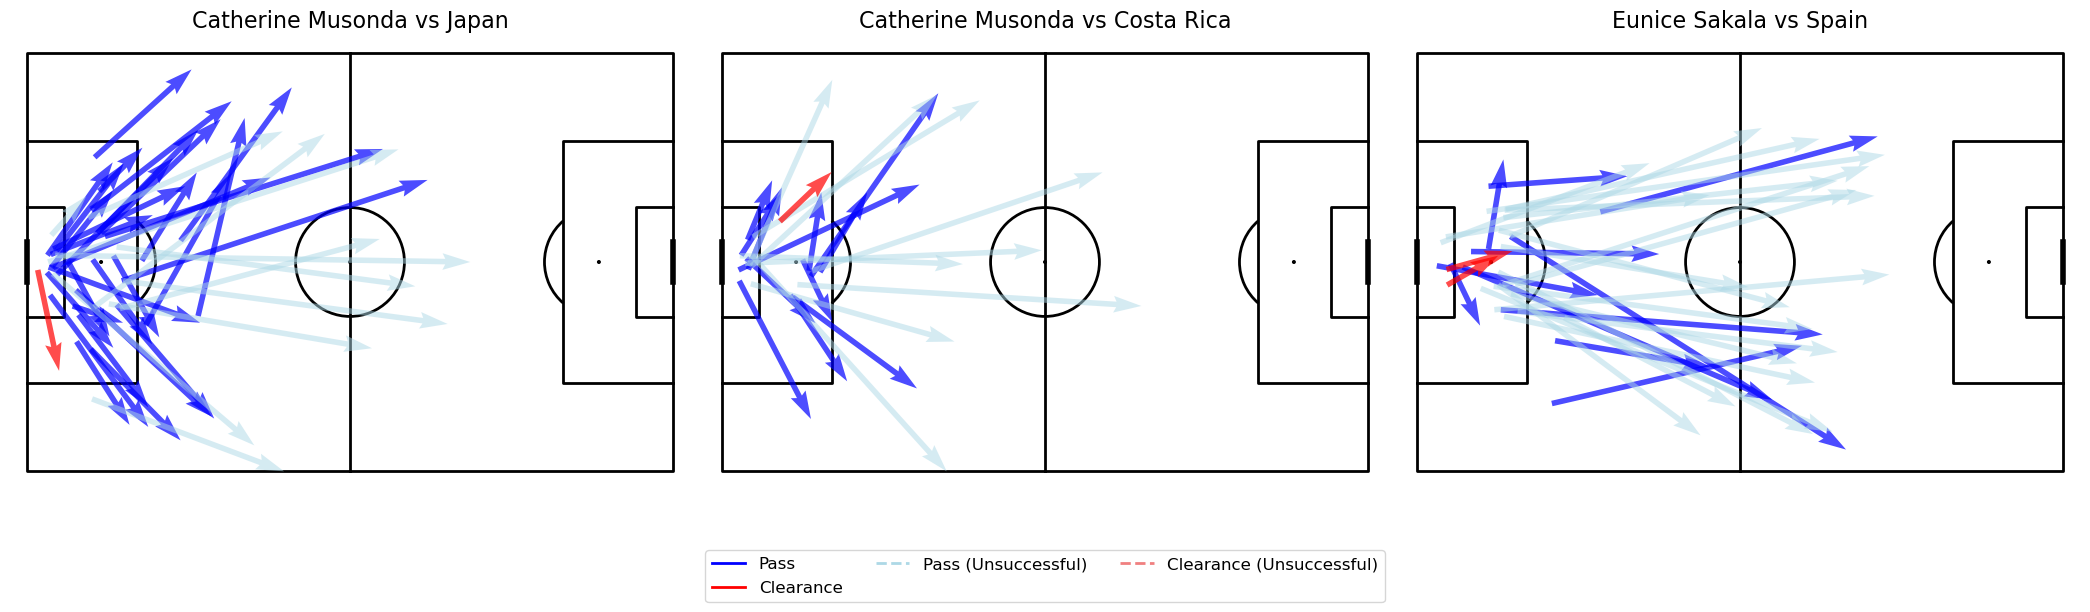

In [53]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Define the matches and goalkeepers
matches = {
    'match_jpn': 'Japan',
    'match_cri': 'Costa Rica',
    'match_esp': 'Spain'
}

# Define goalkeepers and their respective matches
goalkeepers = {
    'match_jpn': 'Catherine Musonda',
    'match_cri': 'Catherine Musonda',
    'match_esp': 'Eunice Sakala'
}

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 7), subplot_kw={'aspect': 'equal'})
for ax in axs:
    ax.set_axis_off()

# Create a single legend entry list
legend_labels = {}

def plot_events(pitch, ax, events, color, light_color, label, legend_labels):
    successful_events = events[events['outcome_type_display_name'] == 'Successful']
    if not successful_events.empty:
        for _, event in successful_events.iterrows():
            start = (event['x'], event['y'])
            end = (event['end_x'], event['end_y'])
            pitch.arrows(start[0], start[1], end[0], end[1], ax=ax, color=color, alpha=0.7)
    
    unsuccessful_events = events[events['outcome_type_display_name'] == 'Unsuccessful']
    if not unsuccessful_events.empty:
        for _, event in unsuccessful_events.iterrows():
            start = (event['x'], event['y'])
            end = (event['end_x'], event['end_y'])
            pitch.arrows(start[0], start[1], end[0], end[1], ax=ax, color=light_color, alpha=0.5)

    if label not in legend_labels:
        legend_labels[label] = color
        legend_labels[f"{label} (Unsuccessful)"] = light_color

for i, (match_id, opponent) in enumerate(matches.items()):
    goalkeeper = goalkeepers[match_id]
    
    # Filter the DataFrame for the current match
    match_df = all_data_df[all_data_df['match_id'] == match_id]
    
    # Filter for the current goalkeeper
    gk_df = match_df[match_df['player_name'] == goalkeeper]
    
    if gk_df.empty:
        print(f"No data for {goalkeeper} in {match_id}")
        continue
    
    # Create pitch and plot on the corresponding axis
    pitch = Pitch(pitch_type='opta', pitch_color='white', line_color='black')
    pitch.draw(ax=axs[i])

    # Plot passes with arrows
    passes = gk_df[gk_df['type_display_name'] == 'Pass']
    if not passes.empty:
        plot_events(pitch, axs[i], passes, color='blue', light_color='lightblue', label='Pass', legend_labels=legend_labels)

    # Plot clearances with arrows
    clearances = gk_df[gk_df['type_display_name'] == 'Clearance']
    if not clearances.empty:
        plot_events(pitch, axs[i], clearances, color='red', light_color='lightcoral', label='Clearance', legend_labels=legend_labels)

    # Set subplot title
    axs[i].set_title(f"{goalkeeper} vs {opponent}", fontsize=16)

# Add legend with unique entries
handles = [plt.Line2D([0], [0], color=color, lw=2) for label, color in legend_labels.items() if ' (Unsuccessful)' not in label]
handles += [plt.Line2D([0], [0], color=color, lw=2, linestyle='--') for label, color in legend_labels.items() if ' (Unsuccessful)' in label]
labels = [label for label in legend_labels.keys() if ' (Unsuccessful)' not in label]
labels += [label for label in legend_labels.keys() if ' (Unsuccessful)' in label]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3, fontsize=12)

plt.tight_layout()
plt.show()


In [21]:
# Define the goalkeepers and their matches
keepers = {
    'Catherine Musonda': ['match_jpn', 'match_cri'],
    'Eunice Sakala': ['match_esp']
}

# Function to calculate percentages
def calculate_pass_percentages(all_data_df):
    total_passes = len(all_data_df)
    successful_passes = len(all_data_df[all_data_df['outcome_type_display_name'] == 'Successful'])
    unsuccessful_passes = len(all_data_df[all_data_df['outcome_type_display_name'] == 'Unsuccessful'])
    
    success_percentage = (successful_passes / total_passes) * 100 if total_passes > 0 else 0
    failure_percentage = (unsuccessful_passes / total_passes) * 100 if total_passes > 0 else 0
    
    return {
        'Total Passes': total_passes,
        'Successful Passes': successful_passes,
        'Unsuccessful Passes': unsuccessful_passes,
        'Success Percentage': success_percentage,
        'Failure Percentage': failure_percentage
    }

# Dictionary to store results
results = {}

# Loop through each goalkeeper and their matches
for keeper, matches in keepers.items():
    # Filter DataFrame for the current goalkeeper
    gk_df = all_data_df[all_data_df['player_name'] == keeper]
    
    # Filter for the matches of the current goalkeeper
    gk_df = gk_df[gk_df['match_id'].isin(matches)]
    
    if gk_df.empty:
        print(f"No data for {keeper}")
        results[keeper] = None
    else:
        # Calculate percentages
        results[keeper] = calculate_pass_percentages(gk_df)

# Print the results
for keeper, stats in results.items():
    if stats:
        print(f"{keeper}:")
        for key, value in stats.items():
            print(f"  {key}: {value:.2f}")
    else:
        print(f"{keeper}: No data available")


Catherine Musonda:
  Total Passes: 108.00
  Successful Passes: 80.00
  Unsuccessful Passes: 28.00
  Success Percentage: 74.07
  Failure Percentage: 25.93
Eunice Sakala:
  Total Passes: 68.00
  Successful Passes: 42.00
  Unsuccessful Passes: 26.00
  Success Percentage: 61.76
  Failure Percentage: 38.24


In [40]:
shot_df = all_data_df[all_data_df['is_shot'] == True] 
shot_df.head()
# Correct way to filter shots that are both is_shot == True and is_goal == True
shots_df = all_data_df[(all_data_df['is_shot'] == True) & (all_data_df['is_goal'] == True) & (all_data_df['match_id'] == 'match_cri')]
# Display the first few rows to verify the filter
shots_df[['player_id', 'x', 'y',
       'end_x', 'end_y', 'qualifiers', 
       'goal_mouth_z', 'goal_mouth_y', 'is_shot', 'card_type', 'is_goal',
       'type_display_name', 'outcome_type_display_name', 'period_display_name',
       'match_id', 'player_name']]

,player_id,x,y,end_x,end_y,qualifiers,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,match_id,player_name
3500,461431,90.3,44.1,None,None,"[{'type': {'value': 79, 'displayName': 'HighCe...",30.4,50.0,True,False,True,Goal,Successful,FirstHalf,match_cri,Lushomo Mweemba
3920,461440,88.5,50.0,None,None,"[{'type': {'value': 103, 'displayName': 'GoalM...",3.2,53.2,True,False,True,Goal,Successful,FirstHalf,match_cri,Barbra Banda
4172,460924,97.0,48.5,None,None,"[{'type': {'value': 103, 'displayName': 'GoalM...",20.9,48.1,True,False,True,Goal,Successful,SecondHalf,match_cri,Mélissa Herrera
4764,461447,91.0,59.4,None,None,"[{'type': {'value': 29, 'displayName': 'Assist...",3.8,48.4,True,False,True,Goal,Successful,SecondHalf,match_cri,Racheal Kundananji


In [37]:
shot_df.columns

Index(['id', 'event_id', 'minute', 'second', 'team_id', 'player_id', 'x', 'y',
       'end_x', 'end_y', 'qualifiers', 'is_touch', 'blocked_x', 'blocked_y',
       'goal_mouth_z', 'goal_mouth_y', 'is_shot', 'card_type', 'is_goal',
       'type_display_name', 'outcome_type_display_name', 'period_display_name',
       'match_id', 'player_name'],
      dtype='object')

In [19]:
filtered_df = shot_df['period_display_name'].unique()
filtered_df

array(['FirstHalf', 'SecondHalf'], dtype=object)

In [14]:
zambia_team_id = 30950
jpn_team_id = 28443
cri_team_id = 30952
esp_team_id = 26886
opponent_team_ids = [30952, 26886, 28443]

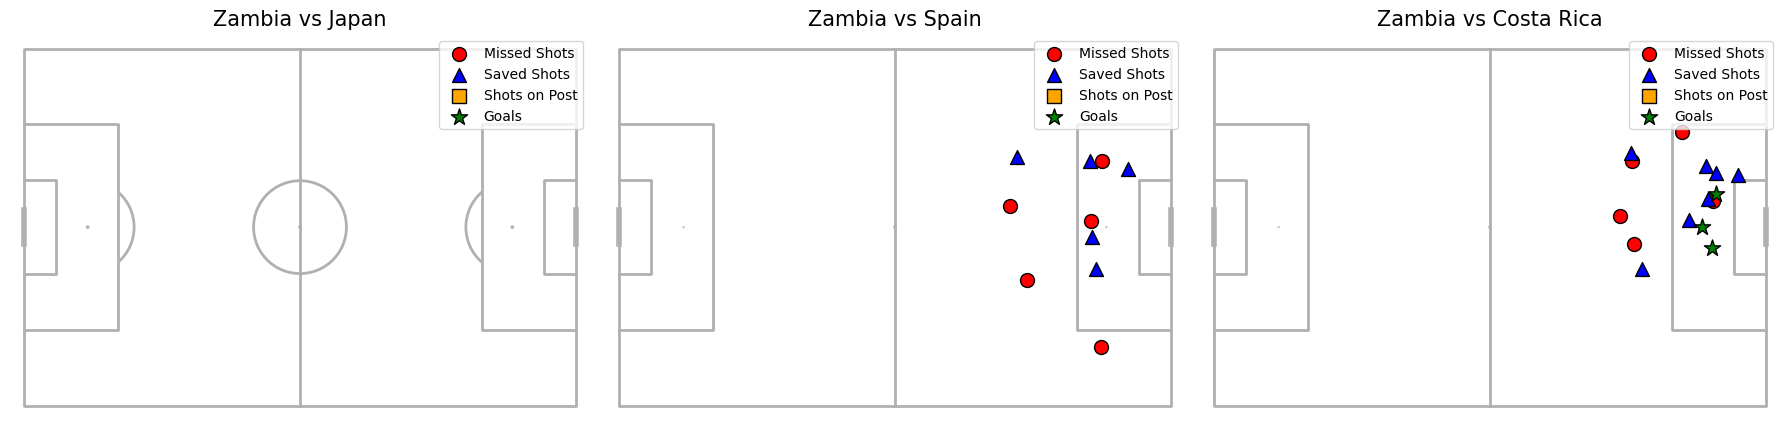

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Dictionary to map match_id to full names
match_names = {
    'match_jpn': 'Japan',
    'match_esp': 'Spain',
    'match_cri': 'Costa Rica'
}

# Function to plot shots for a specific match on a given axis
def plot_shot_map(ax, shot_df, match_id, team_name, team_id):
    # Filter shots for the given match and team
    match_shots = shot_df[(shot_df['match_id'] == match_id) & (shot_df['team_id'] == team_id)]
    
    # Create a pitch
    pitch = Pitch(pitch_type='opta')
    pitch.draw(ax=ax)
    
    # Plot each shot type with different markers/colors
    # Missed Shots
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'MissedShots']['x'],
                  match_shots[match_shots['type_display_name'] == 'MissedShots']['y'],
                  ax=ax, marker='o', color='red', edgecolor='black', s=100, label='Missed Shots')
    
    # Saved Shots
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'SavedShot']['x'],
                  match_shots[match_shots['type_display_name'] == 'SavedShot']['y'],
                  ax=ax, marker='^', color='blue', edgecolor='black', s=100, label='Saved Shots')
    
    # Shots on Post
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'ShotOnPost']['x'],
                  match_shots[match_shots['type_display_name'] == 'ShotOnPost']['y'],
                  ax=ax, marker='s', color='orange', edgecolor='black', s=100, label='Shots on Post')
    
    # Goals
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'Goal']['x'],
                  match_shots[match_shots['type_display_name'] == 'Goal']['y'],
                  ax=ax, marker='*', color='green', edgecolor='black', s=150, label='Goals')
    
    # Add a legend and title
    ax.legend(loc='upper right')
    ax.set_title(f'{team_name} vs {match_names[match_id]}', fontsize=15)

# Define the team_id for Zambia
zambia_team_id = 30950

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot shot maps for each match on different subplots
plot_shot_map(axs[0], shot_df, 'match_jpn', 'Zambia', zambia_team_id)
plot_shot_map(axs[1], shot_df, 'match_esp', 'Zambia', zambia_team_id)
plot_shot_map(axs[2], shot_df, 'match_cri', 'Zambia', zambia_team_id)


# Adjust layout
plt.tight_layout()
plt.show()


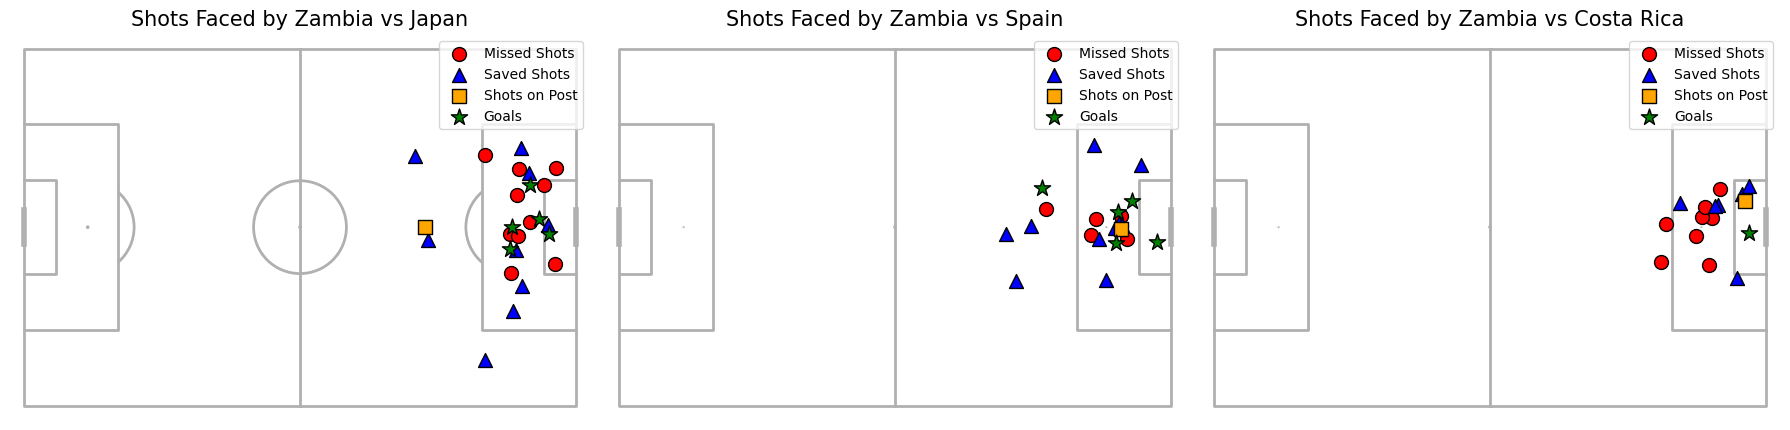

In [301]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Dictionary to map match_id to full names
match_names = {
    'match_jpn': 'Japan',
    'match_esp': 'Spain',
    'match_cri': 'Costa Rica'
}

# Function to plot shots for a specific match on a given axis
def plot_shot_map(ax, shot_df, match_id, opponent_name, team_id):
    # Filter shots for the given match and team (shots faced by Zambia)
    match_shots = shot_df[(shot_df['match_id'] == match_id) & (shot_df['team_id'] != team_id)]
    
    # Create a pitch
    pitch = Pitch(pitch_type='opta')
    pitch.draw(ax=ax)
    
    # Plot each shot type with different markers/colors
    # Missed Shots
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'MissedShots']['x'],
                  match_shots[match_shots['type_display_name'] == 'MissedShots']['y'],
                  ax=ax, marker='o', color='red', edgecolor='black', s=100, label='Missed Shots')
    
    # Saved Shots
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'SavedShot']['x'],
                  match_shots[match_shots['type_display_name'] == 'SavedShot']['y'],
                  ax=ax, marker='^', color='blue', edgecolor='black', s=100, label='Saved Shots')
    
    # Shots on Post
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'ShotOnPost']['x'],
                  match_shots[match_shots['type_display_name'] == 'ShotOnPost']['y'],
                  ax=ax, marker='s', color='orange', edgecolor='black', s=100, label='Shots on Post')
    
    # Goals
    pitch.scatter(match_shots[match_shots['type_display_name'] == 'Goal']['x'],
                  match_shots[match_shots['type_display_name'] == 'Goal']['y'],
                  ax=ax, marker='*', color='green', edgecolor='black', s=150, label='Goals')
    
    # Add a legend and title
    ax.legend(loc='upper right')
    ax.set_title(f'Shots Faced by Zambia vs {opponent_name}', fontsize=15)

# Define the team_id for Zambia
zambia_team_id = 30950

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot shot maps for each match on different subplots
plot_shot_map(axs[0], shot_df, 'match_jpn', 'Japan', zambia_team_id)
plot_shot_map(axs[1], shot_df, 'match_esp', 'Spain', zambia_team_id)
plot_shot_map(axs[2], shot_df, 'match_cri', 'Costa Rica', zambia_team_id)

# Adjust layout
plt.tight_layout()
plt.show()


In [45]:
# Define the team_id for Zambia
zambia_team_id = 30950

# Function to filter shots by Zambia players, display player names, and count shots per player
def get_shot_takers_and_counts(shot_df, match_id, team_id):
    # Filter shots for the given match and team
    match_shots = shot_df[(shot_df['match_id'] == match_id) & (shot_df['team_id'] == team_id)]
    
    # Display the relevant columns
    shot_takers = match_shots[['player_name', 'x', 'y', 'goal_mouth_z', 'goal_mouth_y', 'type_display_name']]
    
    # Count shots per player
    shot_counts = match_shots['player_name'].value_counts().reset_index()
    shot_counts.columns = ['player_name', 'shot_count']
    
    return shot_takers, shot_counts

# Get shot takers and counts for each match
shots_japan, counts_japan = get_shot_takers_and_counts(shot_df, 'match_jpn', zambia_team_id)
shots_spain, counts_spain = get_shot_takers_and_counts(shot_df, 'match_esp', zambia_team_id)
shots_costa_rica, counts_costa_rica = get_shot_takers_and_counts(shot_df, 'match_cri', zambia_team_id)

print("Shots for Zambia vs Japan:")
print(shots_japan)
print("\nShot Counts for Zambia vs Japan:")
print(counts_japan)

print("\nShots for Zambia vs Spain:")
print(shots_spain)
print("\nShot Counts for Zambia vs Spain:")
print(counts_spain)

print("\nShots for Zambia vs Costa Rica:")
print(shots_costa_rica)
print("\nShot Counts for Zambia vs Costa Rica:")
print(counts_costa_rica)


Shots for Zambia vs Japan:
Empty DataFrame
Columns: [player_name, x, y, goal_mouth_z, goal_mouth_y, type_display_name]
Index: []

Shot Counts for Zambia vs Japan:
Empty DataFrame
Columns: [player_name, shot_count]
Index: []

Shots for Zambia vs Spain:
             player_name     x     y goal_mouth_z goal_mouth_y  \
1813        Barbra Banda  86.5  38.2          1.9         48.7   
2106        Barbra Banda  87.6  68.4         77.8         53.3   
2379     Margaret Belemu  73.9  35.3         87.5         50.9   
2749        Barbra Banda  92.2  66.2         19.0         53.7   
2751      Avell Chitundu  85.3  68.6         19.0         49.7   
2844  Racheal Kundananji  85.8  47.2         19.0         48.0   
3171        Barbra Banda  87.4  16.5         73.6         44.2   
3187  Racheal Kundananji  72.1  69.6          3.8         51.4   
3372      Avell Chitundu  85.6  51.8          1.4         71.1   
3423  Racheal Kundananji  70.8  55.9         73.6         49.9   

     type_display_nam

In [97]:
defensive_types = ['Tackle', 'Clearance', 'BlockedPass', 'Interception', 'Challenge', 'KeeperPickup', 'KeeperSweeper', 'Save', 'Smother']
outfield_defensive_types = ['Tackle', 'Clearance', 'BlockedPass', 'Interception', 'Challenge']
defensive_actions_zambia_outfield = zambia_data[zambia_data['type_display_name'].isin(outfield_defensive_types)]

In [98]:
zambia_data = all_data_df[all_data_df['team_id'] == 30950]
defensive_actions_zambia = zambia_data[zambia_data['type_display_name'].isin(defensive_types)]
player_defensive_counts = defensive_actions_zambia.groupby('player_name').size()
print(player_defensive_counts)

player_name
Agness Musesa         22
Avell Chitundu         9
Barbra Banda           8
Catherine Musonda     30
Eunice Sakala         33
Evarine Katongo       18
Hellen Chanda          9
Ireen Lungu           13
Lushomo Mweemba       30
Margaret Belemu       23
Martha Tembo          35
Mary Wilombe           3
Ochumba Lubandji       2
Racheal Kundananji    32
Siomala Mapepa         7
Susan Banda           14
Vast Phiri             1
dtype: int64


In [59]:
def calc_success_rate_zambia(action_type):
    actions = defensive_actions_zambia[defensive_actions_zambia['type_display_name'] == action_type]
    successful = actions[actions['outcome_type_display_name'] == 'Successful']
    total = actions.shape[0]
    return (successful.shape[0] / total) * 100 if total > 0 else 0

tackle_success_rate = calc_success_rate_zambia('Tackle')
print(f"Tackle Success Rate for Zambia: {tackle_success_rate}%")

Tackle Success Rate for Zambia: 57.14285714285714%


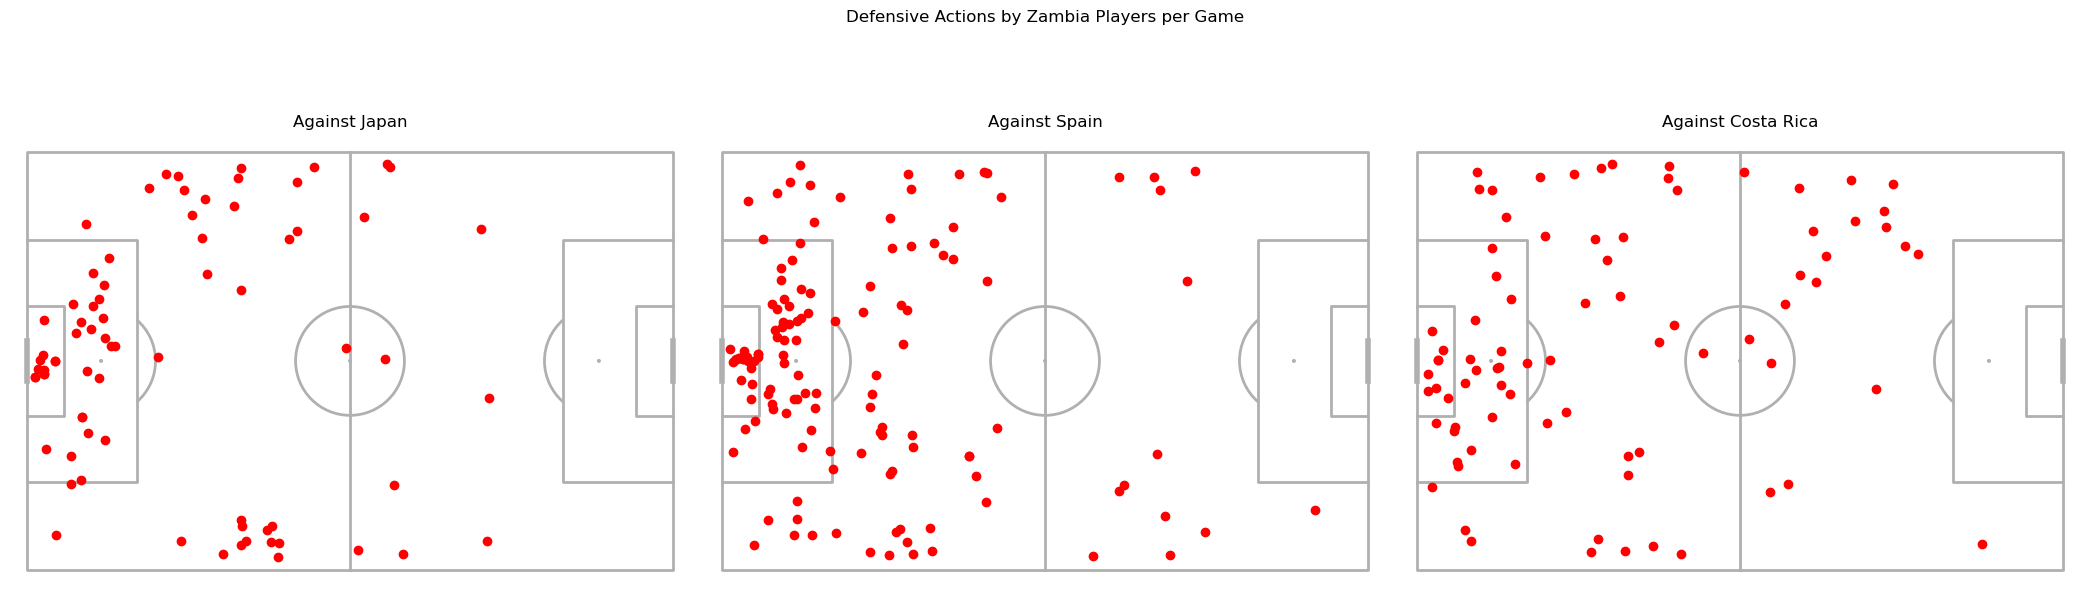

In [99]:
import mplsoccer
import matplotlib.pyplot as plt

# Define match details
matches = {
    'Japan': 'match_jpn',
    'Spain': 'match_esp',
    'Costa Rica': 'match_cri'
}

# Create the pitch
pitch = mplsoccer.Pitch(pitch_type='opta')

# Set up a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)

for ax, (country, match_id) in zip(axs, matches.items()):
    match_data = defensive_actions_zambia[defensive_actions_zambia['match_id'] == match_id]
    
    # Plot defensive actions
    pitch.scatter(match_data['x'], match_data['y'], c='red', label='Defensive Actions', ax=ax)
    pitch.draw(ax=ax)
    
    # Set plot title
    ax.set_title(f'Against {country}')

plt.suptitle('Defensive Actions by Zambia Players per Game')
plt.tight_layout()
plt.show()


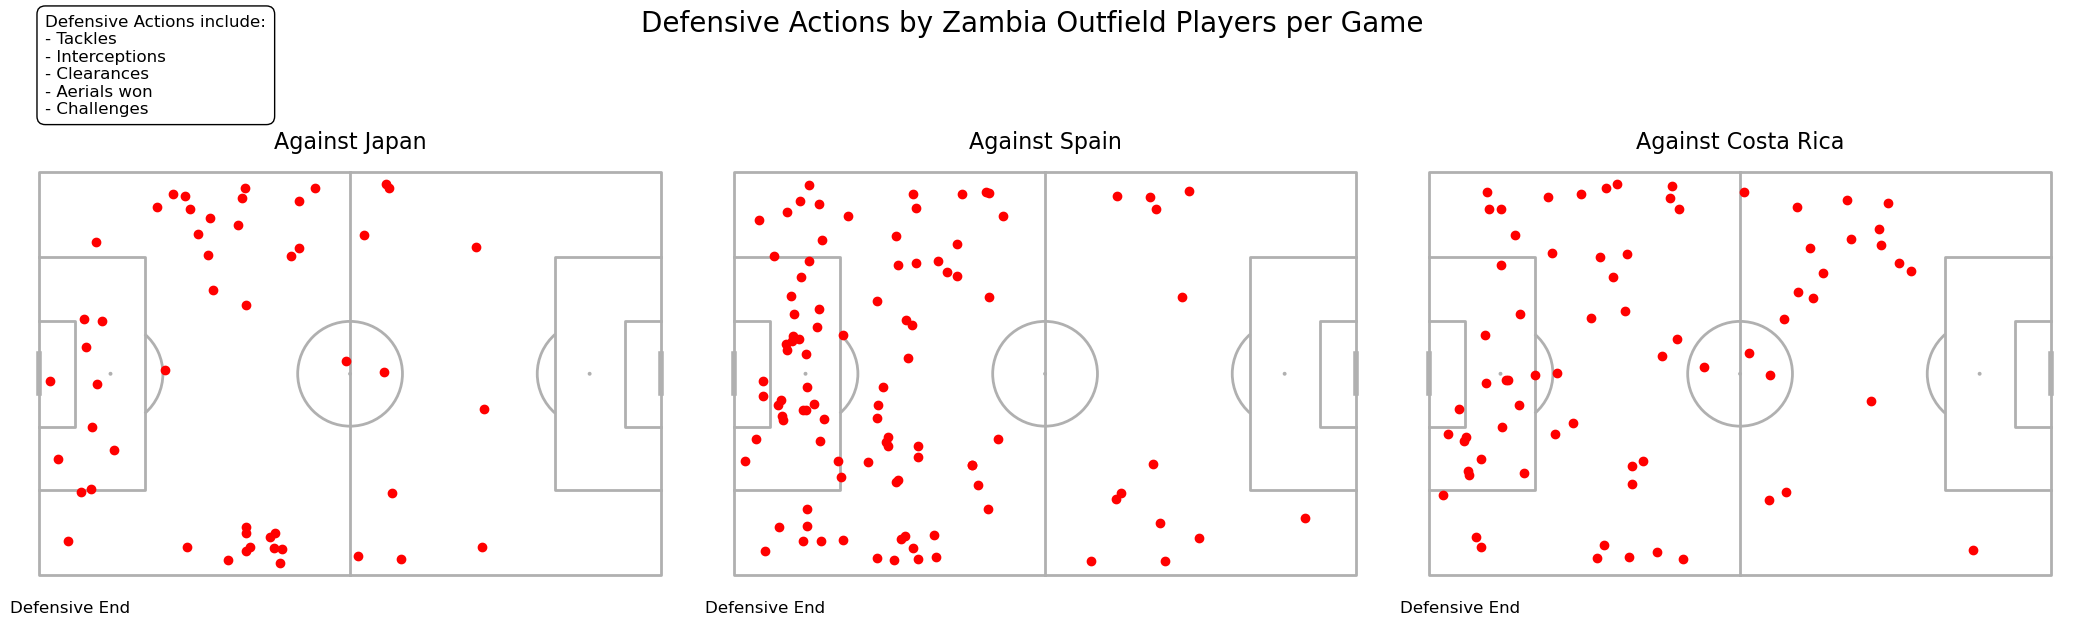

In [107]:
import mplsoccer
import matplotlib.pyplot as plt

# Define match details
matches = {
    'Japan': 'match_jpn',
    'Spain': 'match_esp',
    'Costa Rica': 'match_cri'
}

# Create the pitch
pitch = mplsoccer.Pitch(pitch_type='opta')

# Set up a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)

for ax, (country, match_id) in zip(axs, matches.items()):
    # Filter match data for defensive actions by outfield players
    match_data = defensive_actions_zambia_outfield[defensive_actions_zambia_outfield['match_id'] == match_id]
    
    # Draw the pitch
    pitch.draw(ax=ax)
    
    # Plot defensive actions
    pitch.scatter(match_data['x'], match_data['y'], c='red', label='Defensive Actions', ax=ax)
    
    # Set plot title with larger font size
    ax.set_title(f'Against {country}', fontsize=16)
    
    # Add text indicating the defensive end at the bottom
    ax.text(
        5, -8, 'Defensive End', ha='center', va='center', fontsize=12, color='black'
    )
    
# Add a legend to explain what "Defensive Actions" includes
defensive_actions_text = (
    "Defensive Actions include:\n"
    "- Tackles\n"
    "- Interceptions\n"
    "- Clearances\n"
    "- Aerials won\n"
    "- Challenges"
)

# Add a textbox with explanation on the left side of the plot
fig.text(
    0.03, 0.9, defensive_actions_text, ha='left', va='center', fontsize=12, color='black', transform=fig.transFigure,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)


# Add a common super title with a larger font size
plt.suptitle('Defensive Actions by Zambia Outfield Players per Game', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the super title
plt.show()


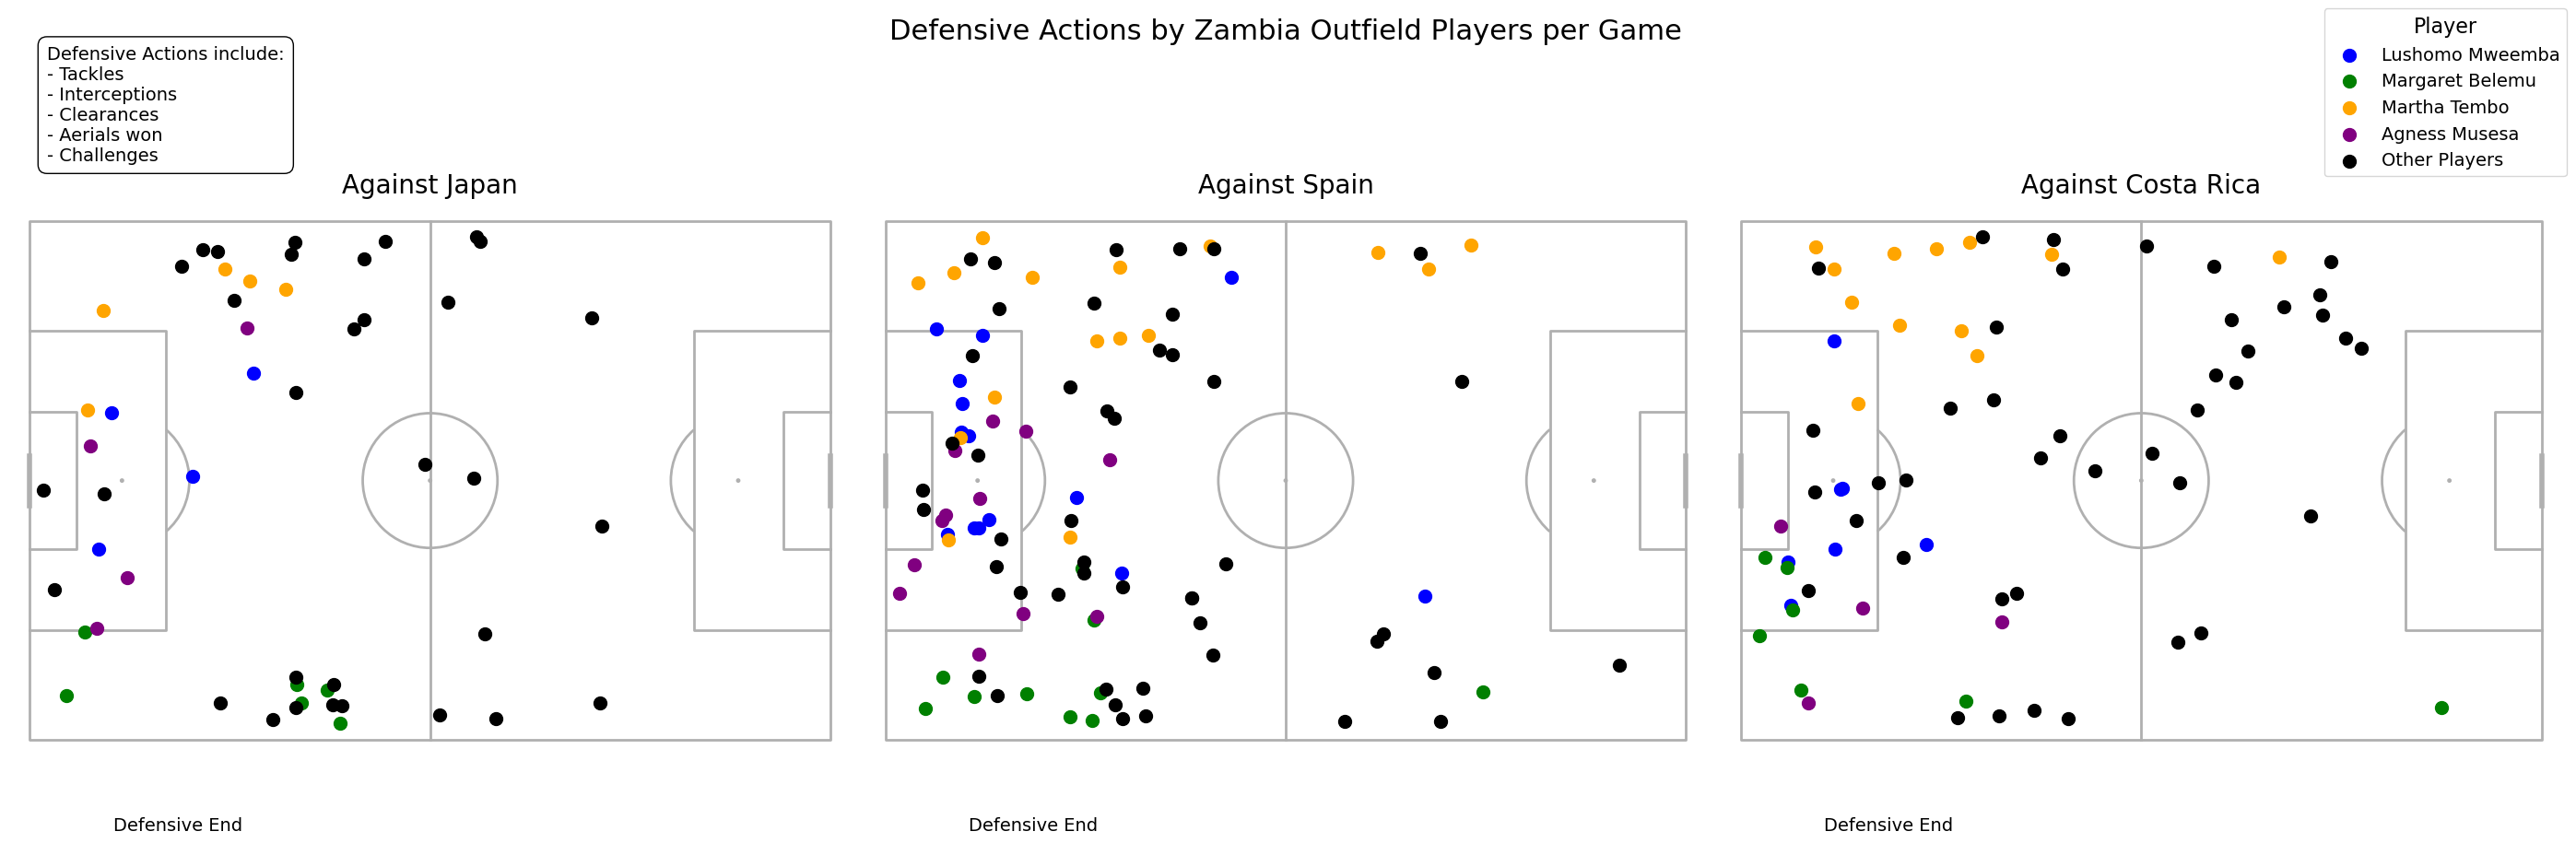

In [266]:
import mplsoccer
import matplotlib.pyplot as plt

# Define match details
matches = {
    'Japan': 'match_jpn',
    'Spain': 'match_esp',
    'Costa Rica': 'match_cri'
}

# Define colors for each defender
defender_colors = {
    'Lushomo Mweemba': 'blue',
    'Margaret Belemu': 'green',
    'Martha Tembo': 'orange',
    'Agness Musesa': 'purple'
}

# Create the pitch
pitch = mplsoccer.Pitch(pitch_type='opta')

# Increase figure size
fig, axs = plt.subplots(1, 3, figsize=(28, 10), sharex=True, sharey=True)

# Define a list to collect legend handles
legend_handles = []

for ax, (country, match_id) in zip(axs, matches.items()):
    # Filter match data for defensive actions by outfield players
    match_data = defensive_actions_zambia_outfield[defensive_actions_zambia_outfield['match_id'] == match_id]
    
    # Draw the pitch
    pitch.draw(ax=ax)
    
    # Plot defensive actions for each defender with a different color
    for defender, color in defender_colors.items():
        defender_data = match_data[match_data['player_name'] == defender]
        scatter = pitch.scatter(defender_data['x'], defender_data['y'], c=color, label=defender, s=100, ax=ax)  # Increase marker size
        
        # Add only one legend handle for each defender to the list
        if ax == axs[0]:  # Only add the legend handles from the first subplot
            legend_handles.append(scatter)
    
    # Plot defensive actions for other players in black
    other_data = match_data[~match_data['player_name'].isin(defender_colors.keys())]
    other_scatter = pitch.scatter(other_data['x'], other_data['y'], c='black', label='Other Players', s=100, ax=ax)  # Increase marker size
    
    # Add only one legend handle for 'Other Players'
    if ax == axs[0]:
        legend_handles.append(other_scatter)
    
    # Set plot title with larger font size
    ax.set_title(f'Against {country}', fontsize=20)

# Add the "Defensive End" text underneath each pitch plot
for ax in axs:
    ax.text(
        0.2, -0.1, 'Defensive End', ha='center', va='top', fontsize=14, color='black', transform=ax.transAxes
    )

# Add a legend for the entire figure in the upper right corner
fig.legend(
    handles=legend_handles, loc='upper right', fontsize=14, title='Player', title_fontsize=16, bbox_to_anchor=(1, 1)
)

# Add a legend to explain what "Defensive Actions" includes
defensive_actions_text = (
    "Defensive Actions include:\n"
    "- Tackles\n"
    "- Interceptions\n"
    "- Clearances\n"
    "- Aerials won\n"
    "- Challenges"
)

# Add a textbox with explanation in the upper left corner of the plot
fig.text(
    0.02, 0.95, defensive_actions_text, ha='left', va='top', fontsize=14, color='black', transform=fig.transFigure,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# Add a common super title 
plt.suptitle('Defensive Actions by Zambia Outfield Players per Game', fontsize=22)

# Adjust layout to make room for the super title and text
plt.tight_layout() 
plt.show()


In [167]:
passes = all_data_df[all_data_df['type_display_name'] == 'Pass']

In [133]:
possession_types = ['Pass', 'BallTouch', 'TakeOn', 'KeeperPickup', 'Dispossessed', 'ShieldBallOpp']
possession_events = all_data_df[all_data_df['type_display_name'].isin(possession_types)]


In [135]:
import pandas as pd

def calculate_possession_duration(events):
    possession_durations = []
    for match_id, group in events.groupby('match_id'):
        previous_event = None
        for _, event in group.iterrows():
            if previous_event is not None and previous_event['team_id'] != event['team_id']:
                duration = event['timestamp'] - previous_event['timestamp']
                possession_durations.append({
                    'match_id': match_id,
                    'team_id': previous_event['team_id'],
                    'duration': duration
                })
            previous_event = event
    return pd.DataFrame(possession_durations)

# Add timestamp
possession_events['timestamp'] = possession_events['minute'] * 60 + possession_events['second']
possession_events = possession_events.sort_values(by=['match_id', 'timestamp'])

possession_durations = calculate_possession_duration(possession_events)
possession_durations

,match_id,team_id,duration
0,match_cri,30950,1.0
1,match_cri,30952,9.0
2,match_cri,30950,2.0
3,match_cri,30952,4.0
4,match_cri,30950,2.0
...,...,...,...
1012,match_jpn,28443,1.0
1013,match_jpn,30950,18.0
1014,match_jpn,28443,17.0
1015,match_jpn,30950,3.0


In [137]:
possession_share = possession_durations.groupby(['match_id', 'team_id']).agg({'duration': 'sum'}).reset_index()
possession_share

,match_id,team_id,duration
0,match_cri,30950,1182.0
1,match_cri,30952,1437.0
2,match_esp,26886,1339.0
3,match_esp,30950,1093.0
4,match_jpn,28443,1997.0
5,match_jpn,30950,908.0


In [277]:
zambia_passes = all_data_df[(all_data_df['team_id'] == 30950) & (all_data_df['type_display_name'] == 'Pass')]

def is_progressive_pass(row, pitch_length=100):
    x_start, y_start = row['x'], row['y']
    x_end, y_end = row['end_x'], row['end_y']
    
    # Calculate distance of the pass
    distance_pass = abs(x_end - x_start)
    
    # Check if the pass moves the ball at least 10 meters
    if x_end - x_start < 10:
        return False
    
    # Calculate remaining distance to goal (assuming goal is at x = 100 for simplicity)
    remaining_distance = 100 - x_start
    
    # Check if the pass moves the ball at least 25% of the remaining distance to goal
    if (distance_pass / remaining_distance) >= 0.25:
        return True
    
    return False


/var/folders/07/r8vgl6rn1_qgfpx0lyfdffph0000gn/T/ipykernel_82168/3755941732.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zambia_passes['is_progressive'] = zambia_passes.apply(is_progressive_pass, axis=1)


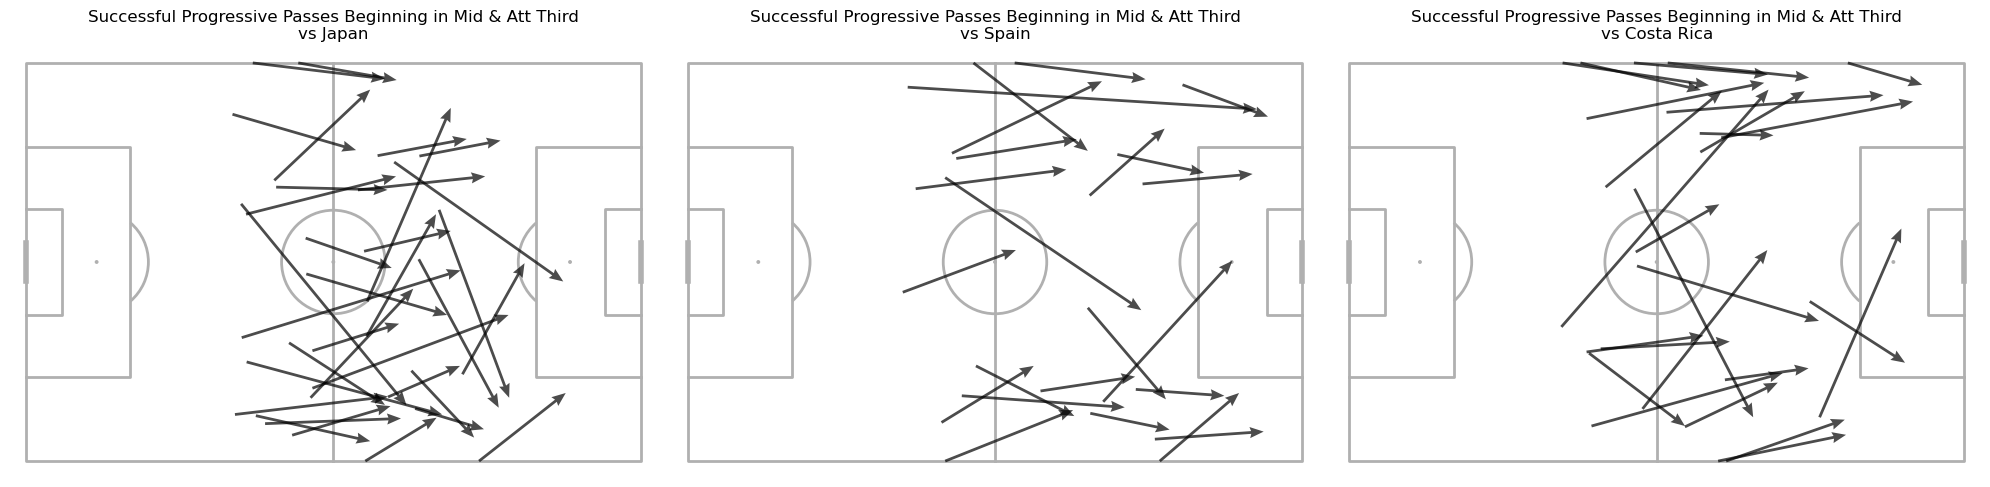

In [287]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Define match details
matches = {
    'Japan': 'match_jpn',
    'Spain': 'match_esp',
    'Costa Rica': 'match_cri'
}

# Define the cutoff for the defensive third
defensive_third_cutoff = 100 / 3

# Apply the updated function to filter progressive passes
zambia_passes['is_progressive'] = zambia_passes.apply(is_progressive_pass, axis=1)

# Further filter for successful passes and exclude those starting in the defensive third
progressive_passes = zambia_passes[
    (zambia_passes['is_progressive']) &
    (zambia_passes['outcome_type_display_name'] == 'Successful') &
    (zambia_passes['x'] > defensive_third_cutoff)
]

# Create a pitch
pitch = Pitch(pitch_type='opta')

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=len(matches), figsize=(20, 7), sharex=True, sharey=True)

# Loop through each match and plot on the corresponding subplot
for ax, (match_name, match_id) in zip(axes, matches.items()):
    # Filter progressive passes for the current match
    match_passes = progressive_passes[progressive_passes['match_id'] == match_id]
    
    # Draw the pitch on the subplot
    pitch.draw(ax=ax)
    
    # Plot progressive passes as arrows
    for _, pass_row in match_passes.iterrows():
        x_start, y_start = pass_row['x'], pass_row['y']
        x_end, y_end = pass_row['end_x'], pass_row['end_y']
        
        # Plot arrow with correct direction
        pitch.arrows(x_start, y_start, x_end, y_end, ax=ax, color='black', width=2, headwidth=4, alpha=0.7)
    
    # Set title for each subplot with opponent's name
    ax.set_title(f'Successful Progressive Passes Beginning in Mid & Att Third\nvs {match_name}')

# Adjust layout
plt.tight_layout()
plt.show()


In [279]:
for match_name, match_id in matches.items():
    match_passes = progressive_passes[progressive_passes['match_id'] == match_id]
    print(f"Match: {match_name}, Number of Passes: {match_passes.shape[0]}")
    print(match_passes.head())


Match: Japan, Number of Passes: 45
            id  event_id  minute second  team_id  player_id     x     y end_x  \
50  2569422165        25       2   20.0    30950     478549  29.6  32.1  53.3   
60  2569422191        30       2   47.0    30950     461413  12.1  56.1  55.1   
61  2569422193        31       2   49.0    30950     461435  57.2  76.7  71.7   
66  2569422203        34       2   57.0    30950     461420  55.5  40.1  69.1   
87  2569422311        46       4   27.0    30950     461442  32.5  56.3  59.2   

   end_y  ... goal_mouth_y  is_shot card_type is_goal type_display_name  \
50  51.5  ...         None    False     False   False              Pass   
60  77.0  ...         None    False     False   False              Pass   
61  80.9  ...         None    False     False   False              Pass   
66  88.7  ...         None    False     False   False              Pass   
87  15.3  ...         None    False     False   False              Pass   

   outcome_type_display_nam

In [291]:
# Iterate over matches and count progressive passes per player
for match_name, match_id in matches.items():
    # Filter for progressive passes for the current match
    match_passes = progressive_passes[progressive_passes['match_id'] == match_id]
    
    # Count the number of passes per player
    passes_per_player = match_passes.groupby('player_name').size().reset_index(name='pass_count')
    
    # Print the results
    print(f"Match: {match_name}, Total Progressive Passes: {match_passes.shape[0]}")
    print(passes_per_player)
    print('\n')  # For better separation between matches


Match: Japan, Total Progressive Passes: 34
           player_name  pass_count
0        Agness Musesa           1
1      Evarine Katongo           5
2          Ireen Lungu           2
3      Lushomo Mweemba           3
4      Margaret Belemu          10
5         Martha Tembo           2
6     Ochumba Lubandji           1
7   Racheal Kundananji           4
8       Siomala Mapepa           2
9          Susan Banda           3
10          Vast Phiri           1


Match: Spain, Total Progressive Passes: 23
           player_name  pass_count
0       Avell Chitundu           3
1         Barbra Banda           1
2      Evarine Katongo           2
3          Ireen Lungu           3
4      Margaret Belemu           4
5         Martha Tembo           2
6         Mary Wilombe           1
7     Ochumba Lubandji           1
8   Racheal Kundananji           4
9       Siomala Mapepa           1
10         Susan Banda           1


Match: Costa Rica, Total Progressive Passes: 26
          player_name 

In [293]:
# Filter the DataFrame to include only shots from Zambia players
zambia_shot_df = all_data_df[(all_data_df['is_shot'] == True) & (all_data_df['team_id'] == 30950)]

# Group the shots by match ID and player name, then count the number of shots
shots_per_player_per_match = zambia_shot_df.groupby(['match_id', 'player_name']).size().reset_index(name='shot_count')

# Print the results
print(shots_per_player_per_match)


     match_id         player_name  shot_count
0   match_cri      Avell Chitundu           1
1   match_cri        Barbra Banda           5
2   match_cri       Hellen Chanda           1
3   match_cri     Lushomo Mweemba           1
4   match_cri        Martha Tembo           1
5   match_cri  Racheal Kundananji           5
6   match_cri         Susan Banda           1
7   match_esp      Avell Chitundu           2
8   match_esp        Barbra Banda           4
9   match_esp     Margaret Belemu           1
10  match_esp  Racheal Kundananji           3


In [297]:
zambia_errors_df = all_data_df[(all_data_df['type_display_name'] == 'Error') & (all_data_df['team_id'] == 30950)]
zambia_errors_df

,id,event_id,minute,second,team_id,player_id,x,y,end_x,end_y,...,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,match_id,player_name
256,2569423831,184,13,54.0,30950,461438,27.3,9.5,None,None,...,None,None,False,False,False,Error,Successful,FirstHalf,match_jpn,Agness Musesa
1318,2569431515,629,77,11.0,30950,461413,7.4,45.1,None,None,...,None,None,False,False,False,Error,Successful,SecondHalf,match_jpn,Catherine Musonda
2525,2570540371,375,49,54.0,30950,461442,9.2,57.2,None,None,...,None,None,False,False,False,Error,Successful,FirstHalf,match_esp,Martha Tembo


In [298]:
# Group the shots by match ID, player name, and type_display_name, then count the number of shots
shots_per_player_per_match = (
    zambia_shot_df
    .groupby(['match_id', 'player_name', 'type_display_name'])
    .size()
    .reset_index(name='shot_count')
)

# Print the results
print(shots_per_player_per_match)


     match_id         player_name type_display_name  shot_count
0   match_cri      Avell Chitundu       MissedShots           1
1   match_cri        Barbra Banda              Goal           1
2   match_cri        Barbra Banda       MissedShots           1
3   match_cri        Barbra Banda         SavedShot           3
4   match_cri       Hellen Chanda       MissedShots           1
5   match_cri     Lushomo Mweemba              Goal           1
6   match_cri        Martha Tembo       MissedShots           1
7   match_cri  Racheal Kundananji              Goal           1
8   match_cri  Racheal Kundananji         SavedShot           4
9   match_cri         Susan Banda       MissedShots           1
10  match_esp      Avell Chitundu       MissedShots           1
11  match_esp      Avell Chitundu         SavedShot           1
12  match_esp        Barbra Banda       MissedShots           2
13  match_esp        Barbra Banda         SavedShot           2
14  match_esp     Margaret Belemu       

---

**Read the full article on my Substack: [Beyond the Touchline - Olympics Preview: USWNT vs Zambia](https://beyondthetouchline.substack.com/p/olympics-preview-uswnt-vs-zambia?r=3gmn6f)**

_This notebook contains the code and analysis behind the article._

---